<a href="https://colab.research.google.com/github/Dav-web/MSC.-Thesis/blob/main/AE_clustering_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Clustering Using AutoEncoder and TF-IDF vectors

In [ ]:
# mount the google drive to read in data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# define file path on google drive
root_path = '/content/gdrive/My Drive/covidvaccine.csv'

## Import LIbraries and Helper Functions

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cluster import k_means
import re
import numpy as np 
import pandas as pd
import pandas as pd
import numpy as np
import sys
import json
import re
import copy
import math

#for text cleaning
import string
import re
import nltk
import itertools as it
import logging
import os
import sys
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import everygrams
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter
!pip install emoji
import emoji
nltk.download('words')
words = set(nltk.corpus.words.words())
from gensim.utils import simple_preprocess

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob 
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
pd.set_option('display.max_colwidth', 400)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Read in data from the data source (Google drive)

In [ ]:
df = pd.read_csv(root_path)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house from North Eastern India.,24-05-2020 10:18,64.0,11.0,110.0,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine,['CovidVaccine'],Twitter Web App,False
1,Shubham Gupta,NaN,I will tell about all experiences of my life from my videos hope that you all like the videos 🙂,14-08-2020 16:42,1.0,17.0,0.0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY,"['CoronavirusVaccine', 'CoronaVaccine', 'CovidVaccine']",Twitter for Android,False
2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is accepting submissions for an upcoming Volume 3 Issue 2. For further queries contact editor@infectiologyjournal.com.,14-12-2017 07:07,143.0,566.0,8.0,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI,NaN,Twitter Web App,False
3,Zane,NaN,Fresher than you.,18-09-2019 11:01,29.0,25.0,620.0,False,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls,NaN,Twitter for Android,False
4,Ann-Maree O’Connor,"Adelaide, South Australia","Retired university administrator. Melburnian by birth, now living in Adelaide. Look back fondly to the Whitlam years; one of Keating’s true believers.",24-01-2013 14:53,83.0,497.0,10737.0,False,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj,NaN,Twitter Web App,False


## Exploratory data analysis

In [ ]:
df.shape

(368588, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368588 entries, 0 to 368587
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         368574 non-null  object 
 1   user_location     289065 non-null  object 
 2   user_description  348130 non-null  object 
 3   user_created      368563 non-null  object 
 4   user_followers    368549 non-null  float64
 5   user_friends      368549 non-null  object 
 6   user_favourites   368549 non-null  object 
 7   user_verified     368549 non-null  object 
 8   date              368547 non-null  object 
 9   text              368549 non-null  object 
 10  hashtags          306913 non-null  object 
 11  source            366135 non-null  object 
 12  is_retweet        368526 non-null  object 
dtypes: float64(1), object(12)
memory usage: 36.6+ MB


In [ ]:
df.describe()

,user_followers
count,3.685490e+05
mean,6.001895e+04
std,7.028443e+05
min,0.000000e+00
25%,1.270000e+02
50%,6.080000e+02
75%,2.796000e+03
max,1.658379e+07


## Data Cleaning and Preprocessing

In [ ]:
import pandas as pd
import re
!pip install emoji
import emoji
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
def replace_urls(in_string, replacement=None):
    """Replace URLs in strings. See also: ``bit.ly/PyURLre``

    Args:
        in_string (str): string to filter
        replacement (str or None): replacment text. defaults to '<-URL->'

    Returns:
        str
    """
    replacement = '<-URL->' if replacement is None else replacement
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    return re.sub(pattern, replacement, in_string)

In [ ]:
replace_urls(df.text[51])

'So glad it works \n\n#Covid_19 #covidph #RussianVaccine #CovidVaccine #PhilHealthcorruption <-URL->'

In [ ]:
def my_tokenizer(in_string):
    """
    Convert `in_string` of text to a list of tokens using NLTK's TweetTokenizer
    """
    # reasonable, but adjustable tokenizer settings
    tokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
    tokens = tokenizer.tokenize(in_string)
    return tokens

In [ ]:
my_tokenizer(df.text[51])

['so',
 'glad',
 'it',
 'works',
 '#covid_19',
 '#covidph',
 '#russianvaccine',
 '#covidvaccine',
 '#philhealthcorruption',
 'https://t.co/kpHnWweJ0i']

In [ ]:
def make_punc_stopwords(max_length=4):
    """Generates punctuation 'words' up to
    ``max_length`` characters.
    """
    def punct_maker(length):
        return ((''.join(x) for x in it.product(string.punctuation,
                                                repeat=length)))
    words = it.chain.from_iterable((punct_maker(length)
                                    for length in range(max_length+1)))
    return list(words)

In [ ]:
!pip install nltk
from nltk.corpus import stopwords
my_stopwords = set(stopwords.words('english'))

In [ ]:
my_stopwords = list(it.chain(my_stopwords, make_punc_stopwords(max_length=4)))

print('current count of stopwords: {}'.format(len(my_stopwords)))
print('example punctuation words:\n {}'.format(my_stopwords[-10:]))

current count of stopwords: 1082580
example punctuation words:
 ['~~~[', '~~~\\', '~~~]', '~~~^', '~~~_', '~~~`', '~~~{', '~~~|', '~~~}', '~~~~']


In [ ]:
import pandas as pd
import re
import gensim
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'RT', 'amp', 'afp'])

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    #Remove hashtag sign but keep the text
    #tweet = tweet.replace("#", "").replace("_", " ") 
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet, deacc=True, min_len=2):  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['tweet'] = df['text'].map(lambda x: preprocess_tweet(x))

In [ ]:
pd.set_option('display.max_colwidth', 400)
df[['tweet', 'text']].head()

,tweet,text
0,australia to manufacture covid vaccine and give it to the citizens for free of cost afp quote prime minister,Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine
1,australia be do very good,#CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY
2,deaths due to covid in affect countries read more,Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI
3,stay safe di amp da,@Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls
4,this be what pass for leadership in our country voucher for something that,@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj


## Build the TF-IDF Vectors for the Data Clustering Task

In [ ]:
unique_tweet_cnt = len(set(df.text))

In [ ]:
vec = TfidfVectorizer(min_df=2,
                      stop_words=my_stopwords,
                      max_features=unique_tweet_cnt//100,
                     )

In [ ]:
tfidf_matrix = vec.fit_transform(df['tweet'].values.astype(str))

In [ ]:
print(tfidf_matrix.shape), print(type(tfidf_matrix))

(368588, 3682)
<class 'scipy.sparse.csr.csr_matrix'>


(None, None)

In [ ]:
tfidf_matrix

<368588x3682 sparse matrix of type '<class 'numpy.float64'>'
	with 2976917 stored elements in Compressed Sparse Row format>

In [ ]:
print(vec.vocabulary_)

{'australia': 260, 'manufacture': 1975, 'covid': 778, 'vaccine': 3463, 'give': 1406, 'citizens': 594, 'free': 1343, 'cost': 756, 'quote': 2632, 'prime': 2534, 'minister': 2059, 'good': 1419, 'deaths': 857, 'due': 1017, 'affect': 75, 'countries': 763, 'read': 2661, 'stay': 3103, 'safe': 2843, 'di': 924, 'amp': 142, 'da': 826, 'pass': 2354, 'leadership': 1868, 'country': 764, 'something': 3043, 'multi': 2122, 'system': 3202, 'syndrome': 3200, 'children': 574, 'disease': 957, 'well': 3584, 'let': 1885, 'qualify': 2617, 'would': 3644, 'anyone': 173, 'party': 2353, 'get': 1400, 'rush': 2835, 'test': 3247, 'come': 658, 'russia': 2836, 'without': 3619, 'ability': 4, 'make': 1962, 'locally': 1915, 'force': 1318, 'rely': 2732, 'others': 2299, 'like': 1902, 'us': 3438, 'china': 576, 'zoom': 3679, 'chart': 556, 'st': 3083, 'week': 3575, 'hear': 1513, 'episode': 1110, 'executive': 1171, 'contract': 731, 'coronavirus': 748, 'inform': 1697, 'twitter': 3382, 'great': 1448, 'news': 2185, 'enter': 1102

In [ ]:
(pd.DataFrame(tfidf_matrix[:10].todense(),
              columns=[x for x in vec.get_feature_names()])
 # experiment by choosing any range of feature indices (alphabetical order)
 .iloc[:,900:920])

,depend,dependent,deploy,deployment,dept,deputy,desantis,describe,desert,deserve,design,desperate,desperately,despite,destroy,destruction,detail,detect,determine,devastate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimensionality Reduction

In [ ]:
from sklearn.preprocessing import normalize
vector_normalized = normalize(tfidf_matrix, norm='l1', axis=1, copy=False)
vector_normalized.shape

(368588, 3682)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn import datasets
import numpy as np

In [ ]:
tsvd = TruncatedSVD(n_components=2000)

In [ ]:
sparse_tsvd = tsvd.fit(vector_normalized).transform(vector_normalized)
sparse_tsvd.shape

(368588, 2000)

In [ ]:
tsvd.explained_variance_ratio_[0:2000].sum()

0.899736844807205

In [ ]:
from sklearn.model_selection import train_test_split
X = sparse_tsvd
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape), print(X_test.shape)

(294870, 2000)
(73718, 2000)


(None, None)

## Build and Train the AutoEncoder Model

In [ ]:
from keras.layers import Dense, Input
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from datetime import datetime

In [ ]:
def get_autoencoder(dims, act='relu'):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')

    h = x
    for i in range(n_stacks - 1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)

    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks - 1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)

    h = Dense(dims[0], name='decoder_0')(h)

    model = Model(inputs=x, outputs=h)
    model.summary()
    return model

In [ ]:
batch_size = 256
pretrain_epochs = 256
encoded_dimensions = 100
shape = [X.shape[-1], 2048, 3072, 4096, 8192, encoded_dimensions]

print(shape)

autoencoder = get_autoencoder(shape)

[2000, 2048, 3072, 4096, 100]
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2000)]            0         
                                                                 
 encoder_0 (Dense)           (None, 2048)              4098048   
                                                                 
 encoder_1 (Dense)           (None, 3072)              6294528   
                                                                 
 encoder_2 (Dense)           (None, 4096)              12587008  
                                                                 
 encoder_3 (Dense)           (None, 100)               409700    
                                                                 
 decoder_3 (Dense)           (None, 4096)              413696    
                                                                 
 decoder_2 (Dense)           

In [ ]:
encoded_layer = f'encoder_{(len(shape) - 2)}'

print(f'taking the last encoder layer:{encoded_layer}')

hidden_encoder_layer = autoencoder.get_layer(name=encoded_layer).output
encoder = Model(inputs=autoencoder.input, outputs=hidden_encoder_layer)
autoencoder.compile(loss='mse', optimizer='adam')

taking the last encoder layer:encoder_3


In [ ]:
#train the autoencoder
model_series = 'CLS_MODEL_' + datetime.now().strftime("%h%d%Y-%H%M")

checkpointer = ModelCheckpoint(filepath=f"{model_series}-model.h5", 
                               verbose=0, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.000000001, 
                               patience=10, verbose=1, mode='auto', 
                               restore_best_weights=True)

model_history = autoencoder.fit(
                                  X_train,
                                  X_train,
                                  batch_size=batch_size,
                                  epochs=pretrain_epochs,
                                  verbose=1,
                                  validation_data=(X_test, X_test),
                                  callbacks=[checkpointer, early_stopping]
                              )

autoencoder = load_model(f"{model_series}-model.h5")

Epoch 1/512
1152/1152 [==============================] - 26s 21ms/step - loss: 7.7488e-05 - val_loss: 6.8646e-05
Epoch 2/512
1152/1152 [==============================] - 22s 19ms/step - loss: 6.2529e-05 - val_loss: 5.9502e-05
Epoch 3/512
1152/1152 [==============================] - 22s 19ms/step - loss: 5.6600e-05 - val_loss: 5.4830e-05
Epoch 4/512
1152/1152 [==============================] - 22s 19ms/step - loss: 5.2074e-05 - val_loss: 5.0663e-05
Epoch 5/512
1152/1152 [==============================] - 23s 20ms/step - loss: 4.8615e-05 - val_loss: 4.7842e-05
Epoch 6/512
1152/1152 [==============================] - 22s 19ms/step - loss: 4.6129e-05 - val_loss: 4.5659e-05
Epoch 7/512
1152/1152 [==============================] - 22s 19ms/step - loss: 4.4167e-05 - val_loss: 4.3912e-05
Epoch 8/512
1152/1152 [==============================] - 22s 19ms/step - loss: 4.2482e-05 - val_loss: 4.2306e-05
Epoch 9/512
1152/1152 [==============================] - 22s 19ms/step - loss: 4.1003e-05 - val_

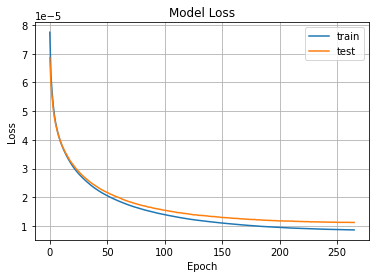

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)

## Model Prediction

In [ ]:
from os import mkdir; 
#mkdir('[saved_models]')
!pwd
!ls

/content
 CLS_MODEL_Mar122022-0155-model.h5   gdrive	  '[saved_models]'
 CLS_MODEL_Mar122022-0322-model.h5   sample_data


In [ ]:
# save its weights
weights_name = '[saved_models]/' + model_series + "-" + str(pretrain_epochs) + '-ae_weights.h5'
#autoencoder.save_weights(weights_name)

In [ ]:
# use the weights learned by the encoder to encode the data 
 # to a representation (embedding)
X_encoded = encoder.predict(X)

In [ ]:
def learn_manifold(x_data, umap_min_dist=0.00, umap_metric='cosine',
                   umap_dim=10, umap_neighbors=30):
    md = float(umap_min_dist)
    return umap.UMAP(
        random_state=42,
        metric=umap_metric,
        n_components=umap_dim,
        low_memory=True,
        n_neighbors=umap_neighbors,
        min_dist=md).fit_transform(x_data)

In [ ]:
!pip install umap-learn
!pip install pynndescent
!pip install llvmpy=='0.12.7-9-g60b512d'
!pip install cython
!pip install numba
import umap

     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 19.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=7d661180a37e22c33116a04d4090ebaa482193624d8ea3ff4a1ddccc306b6bfc
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=bdd7556f1d456ffb10e711e68c9b8e9d73bf7f484331ca5e55c6ac99946ff626
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
     |████████████████████████████████| 1.1 MB 7.8 MB/s 
ERROR: Could not find a version that satisfies the requirement llvmpy==0.12.7-9-g60b512d (from versions: 0.12.7-9-g60b512d, 0.8.2, 0.9, 0.10.0, 0.10.1, 0.10.2, 0.11.0, 0.11.2, 0.12.4, 0.12.5, 0.12.6, 0.12.7)
ERROR: No matching distribution found for llvmp

In [ ]:
X_reduced = learn_manifold(X_encoded, umap_neighbors=100, 
                           umap_dim=int(encoded_dimensions/2))

## Clustering the Data using Kmeans and HDBSCAN

In [ ]:
# this is the data that we need to cluster
!pip install hdbscan
import hdbscan

hdbs = hdbscan.HDBSCAN(min_cluster_size=1000,
                                min_samples=200,
                               prediction_data=True,
                               core_dist_n_jobs=-1,
                              gen_min_span_tree=True,
                              algorithm='best'
                               )

hdbscan_labels = hdbs.fit_predict(X_reduced)

hdbscan_cluster = hdbs.fit(X_reduced)

     |████████████████████████████████| 5.2 MB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330850 sha256=b14d5922bba3b0aca2132ba4a0772c34b7a356b1b63f53727026f33656fa6c6a
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [ ]:

!pip install hdbscan
import hdbscan
hdbscan_cluster = hdbscan.HDBSCAN(algorithm='best', 
                                  min_samples=200, 
                                  min_cluster_size=1000, core_dist_n_jobs=-1,
                                  gen_min_span_tree=True).fit(X_reduced)

In [ ]:
unique, counts = np.unique(hdbscan_cluster.labels_, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    -1   3967]
 [     0   1185]
 [     1   1676]
 [     2   1025]
 [     3   1074]
 [     4   1416]
 [     5 358245]]


Text(0.5, 1.0, 'kmeans parameter search')

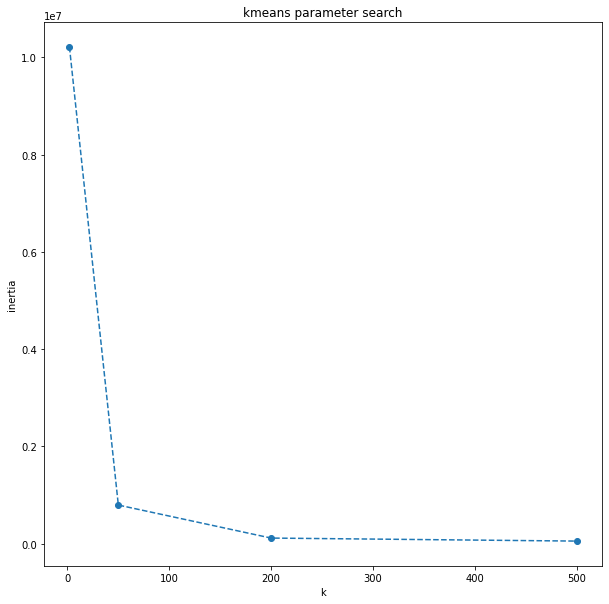

In [ ]:
# compare a broad range of ks to start
from sklearn.cluster import KMeans
ks = [2, 50, 200, 500]


# track a couple of metrics

inertias = []
import logging
# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_reduced)
    labels = model.labels_
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
plt.figure(figsize=(10,10))

plt.plot(ks, inertias, 'o--')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

In [ ]:
from sklearn.cluster import KMeans
k_means = KMeans(init ='k-means++', n_clusters= 7, n_init = 24, 
                 max_iter=500, random_state=42)
k_means.fit(X_reduced)
K_labels = k_means.labels_
print(K_labels)

[0 3 3 ... 0 3 5]


In [ ]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(hdbscan_cluster.labels_== this_label)[0]
            coeff_sums = np.sum(tfidf_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')

In [ ]:
strongest_features(k_means, vec, topk=15)

Cluster 0: absolutely activity achieve abt absolute abingdon add abroad aaron abc ache across act account ability
Cluster 1: abduct abc aaron absolute absolutely abt achieve abroad activity add across act ache activities account
Cluster 2: absolutely absolute achieve abingdon abroad activity abt add abc act ache across activities ability account
Cluster 3: abingdon absolutely aaron activity abt absolute abroad achieve ache account abc act ability across ad
Cluster 4: absolutely aaron abc achieve absolute activity abt add abroad act ache across activities account ad
Cluster 5: abingdon absolutely aaron abt activity achieve abc add absolute ability ache across act activities account
Cluster 6: able abingdon absolutely aaron achieve abt absolute activity abc add act abroad ache ability across


In [ ]:
strongest_features(hdbscan_cluster, vec, topk=15)

Cluster 0: slot availability pm pay free family fast fascinate farm far faqs faq fantastic fancy fan 
Cluster 1: dose slot availability pm pay free covaxin nd ji meanwhile currently due may th wait 
Cluster 2: slot availability pay free reserve citizen allocate available follow doctor may mean book indicate centre 
Cluster 3: dose slot availability pm pay free campus tomorrow moderna open appointment first faqs zydus far 
Cluster 4: dose slot availability pay free zydus fast fascinate farm far faqs faq fantastic fancy fan 
Cluster 5: get vaccine covid dose vaccinate first people today amp vaccination take thank go say one 


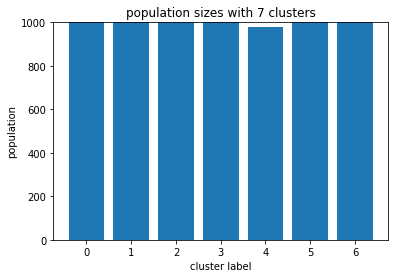

In [ ]:
plt.bar(range(len(set(k_means.labels_))), np.bincount(k_means.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(len(set(k_means.labels_))));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);

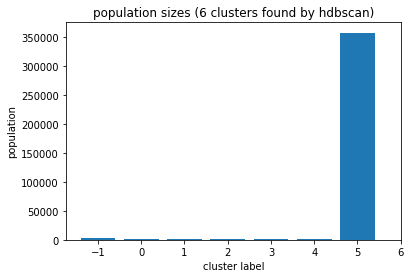

In [ ]:
# get the population sizes
label_counts = Counter(hdbscan_cluster.labels_)
xs, ys = [], []
for k,v in label_counts.items():
    xs.append(k)
    ys.append(v)

# draw the chart
plt.bar(xs, ys)

plt.xticks(range(-1, len(label_counts)))
plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes ({} clusters found by hdbscan)'.format(len(label_counts) - 1));

In [ ]:
#important to note that the clustering was performed on the result of UMAP
# but the 2 dim lowering here (in order to generate the plot - was performed on the result of the encoder only)
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(X_encoded)

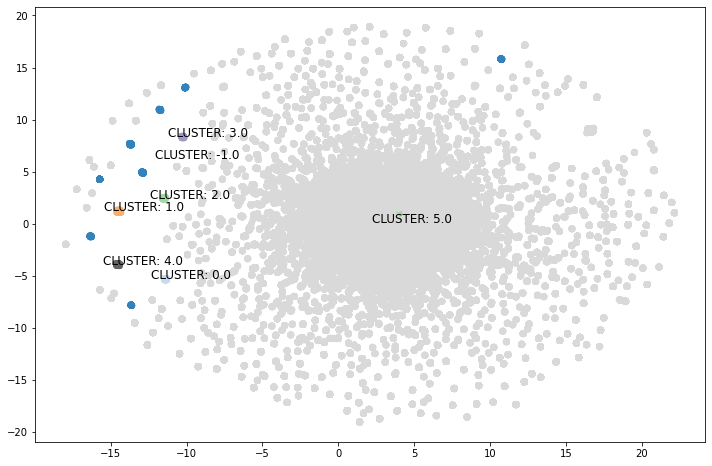

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=hdbscan_cluster.labels_, cmap='tab20c')

viz_clusters = pd.DataFrame(embedding)
viz_clusters['cluster'] = hdbscan_cluster.labels_

for row in viz_clusters.groupby('cluster').mean().reset_index().values:
    label = f'CLUSTER: {row[0]}'
    plt.annotate(label, (row[1], row[2]), textcoords="offset points", fontsize=12,  xytext=(25,0), ha='center')

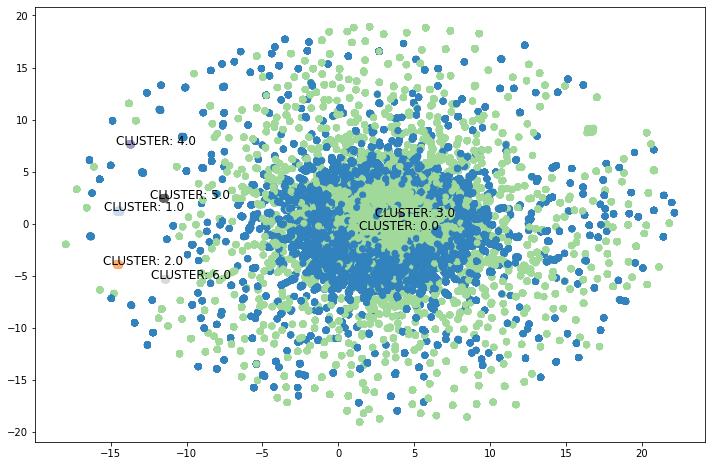

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=K_labels, cmap='tab20c')

viz_clusters = pd.DataFrame(embedding)
viz_clusters['cluster'] = K_labels

for row in viz_clusters.groupby('cluster').mean().reset_index().values:
    label = f'CLUSTER: {row[0]}'
    plt.annotate(label, (row[1], row[2]), textcoords="offset points", fontsize=12,  xytext=(25,0), ha='center')

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(X_reduced, hdbscan_cluster.labels_)

0.8333066

In [ ]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(X_reduced, hdbscan_cluster.labels_)

38590.405597439065

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X_reduced, hdbscan_cluster.labels_)

1.3484483662412166

In [ ]:
silhouette_score(X_reduced, K_labels)

0.28065386

In [ ]:
calinski_harabasz_score(X_reduced, K_labels)

43175.86181584051

In [ ]:
davies_bouldin_score(X_reduced, K_labels)

0.6554948276725909

In [ ]:
hdbscan_cluster.relative_validity_

0.05504926721526436

## Hyper-parameter Tuning

In [ ]:
from sklearn.metrics import silhouette_score
sil1 = []
kmax = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in kmax:
  kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=500, random_state=42).fit(X_reduced)
  labels = kmeans.labels_
  sil1.append(silhouette_score(X_reduced, labels, metric = 'cosine'))

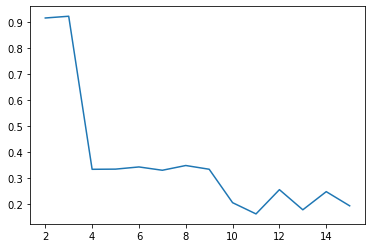

In [ ]:
k1 = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]).T
k1 = k1.reshape(14,1)
plt.plot(k1, sil1)

In [ ]:
k_means2 = KMeans(n_clusters = 3, init='k-means++', max_iter=500, random_state=42).fit(X_reduced)
klabels = k_means2.labels_

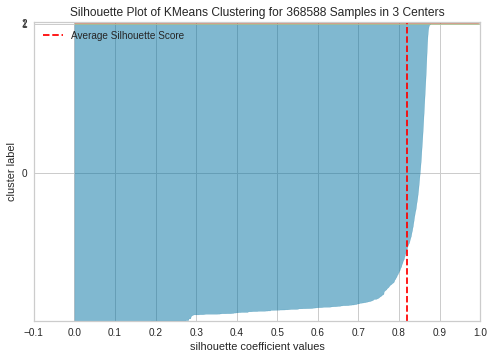

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(k_means2, colors='yellowbrick')
visualizer.fit(X_reduced)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
silhouette_score(X_reduced, klabels, metric = 'cosine')

0.9231058

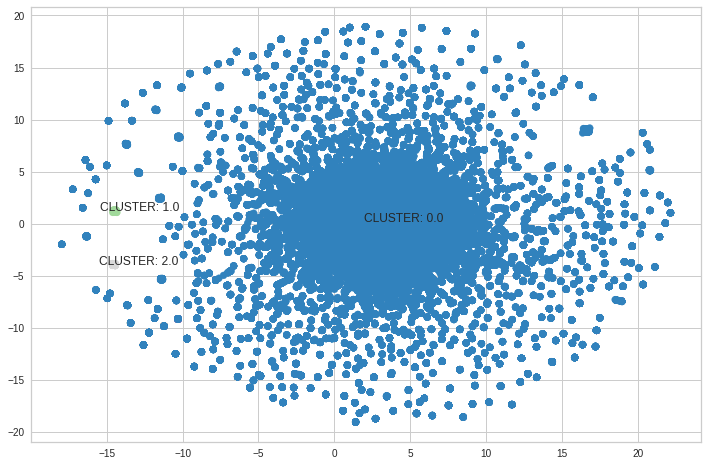

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=klabels, cmap='tab20c')

viz_clusters = pd.DataFrame(embedding)
viz_clusters['cluster'] = klabels

for row in viz_clusters.groupby('cluster').mean().reset_index().values:
    label = f'CLUSTER: {row[0]}'
    plt.annotate(label, (row[1], row[2]), textcoords="offset points", fontsize=12,  xytext=(25,0), ha='center')

In [ ]:
df['Cluster'] = klabels

In [ ]:
df.head(100)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tweet,Cluster
0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house from North Eastern India.,24-05-2020 10:18,64.0,11.0,110.0,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine,['CovidVaccine'],Twitter Web App,False,australia to manufacture covid vaccine and give it to the citizens for free of cost afp quote prime minister,0
1,Shubham Gupta,NaN,I will tell about all experiences of my life from my videos hope that you all like the videos 🙂,14-08-2020 16:42,1.0,17.0,0.0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY,"['CoronavirusVaccine', 'CoronaVaccine', 'CovidVaccine']",Twitter for Android,False,australia be do very good,0
2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is accepting submissions for an upcoming Volume 3 Issue 2. For further queries contact editor@infectiologyjournal.com.,14-12-2017 07:07,143.0,566.0,8.0,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI,NaN,Twitter Web App,False,deaths due to covid in affect countries read more,0
3,Zane,NaN,Fresher than you.,18-09-2019 11:01,29.0,25.0,620.0,False,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls,NaN,Twitter for Android,False,stay safe di amp da,0
4,Ann-Maree O’Connor,"Adelaide, South Australia","Retired university administrator. Melburnian by birth, now living in Adelaide. Look back fondly to the Whitlam years; one of Keating’s true believers.",24-01-2013 14:53,83.0,497.0,10737.0,False,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj,NaN,Twitter Web App,False,this be what pass for leadership in our country voucher for something that,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,the indian national daily,India,"India's NEWS Channel for Digital Media!\nTo get in touch with us, send a Direct Message",02-06-2014 07:15,1057.0,124.0,275.0,False,17-08-2020 15:46,National Expert Group on Vaccine Administration meets the Domestic Vaccine Manufactures\nPIB (@PIB_India)… https://t.co/Eoci6vseWv,NaN,Twitter Web App,False,national expert group on vaccine administration meet the domestic vaccine manufacture pib,0
96,Kev a man with a spud gun wielding hedgehog,"northampton, middle england","Northampton born MK. bred tax exile alleged genius bipolar maniac currently on major meds change, Twitter is planets piss take platform and I take no prisoners",29-09-2019 12:25,53.0,64.0,1721.0,False,17-08-2020 15:39,"@BBCNews You pay me £5,000 cash tax free and I’ll take the chance..as this my life you playing with and .you can st… https://t.co/dHiuzEDwq2",NaN,Twitter Web App,False,you pay me cash tax free and ll take the chance as this my life you play with and you can st,0
97,Murtuza Merchant,Mumbai,Journalist,27-07-2013 09:40,439.0,123.0,948.0,False,17-08-2020 15:37,Doctors seeking @rautsanjay61 's resignation from #Maharashtra CM @uddhavthackeray \n\n#DoctorSecondSingle #Doctor… https://t.co/HE5G7kQtTE,"['Maharashtra', 'DoctorSecondSingle', 'Doctor']",Twitter for Android,False,doctor seek resignation from cm,0
98,ً,NaN,#JENNIE: most hated — i’m a fan account 😒 (she/her),22-10-2016 21:38,1011.0,1005.0,19770.0,False,17-08-2020 15:24,#Corona #iHeartDynamite #iHeartDay1Contest #CovidVaccine #Trump2020 #BidenHarrisLandslide2020 #MAGA donald trump jo… https://t.co/D9CwLkIgBl,"['Corona', 'iHeartDynamite', 'iHeartDay1Contest', 'CovidVaccine', 'Trump2020', 'BidenHarrisLandslide2020', 'MAGA']",Twitter for iPh

In [ ]:
strongest_features(k_means2, vec, topk=15)

Cluster 0: absolutely abingdon activity abt aaron absolute achieve abroad ache abc act account across ability add
Cluster 1: abduct abc aaron absolute absolutely abt achieve abroad activity add across act ache activities account
Cluster 2: absolutely absolute achieve abingdon abroad activity abt add abc act ache across activities ability account


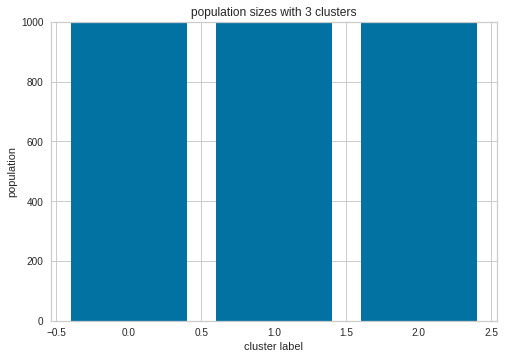

In [ ]:
plt.bar(range(len(set(k_means2.labels_))), np.bincount(k_means2.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(len(set(k_means2.labels_))));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);